# Analyzing NYC High School Data

One of the most controversial issues in the U.S. educational system is the efficacy of standardized tests and whether they are unfair to certain groups. 

The Scholastic Aptitude Test(SAT), is an exam taken by U.S. high school students before applying to college. Colleges take the test scores into account when deciding who to admit, so it's important to perform well.

The test consists of three sections, each of which has 800 points maximum. The combined score is 2,400 for all the sections. Organizations often rank high schools by their average SAT scores. The scores are also considered a measure of overall school district quality.

Given the prior knowledge of this topic, investigating the correlations between SAT scores and demographics might be an interesting angle to consider. We could correlate SAT scores with factors like race, gender, income, and more.

New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For instance, if certain racial groups consistently perform better, we would have some evidence that the SAT is unfair.

## Data Cleaning 

### Read in the Data

In [1]:
# Import necessary modules
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

data_files = ['ap_2010.csv','class_size.csv','demographics.csv',
               'graduation.csv', 'hs_directory.csv', 'sat_results.csv'
             ]

data = {file.replace('.csv','') : pd.read_csv(file) for file in data_files} #Read all the files into a dict

### Read in the surveys

In [2]:
all_survey = pd.read_csv('all_survey.txt', delimiter = '\t', encoding = 'windows-1252')
d75_survey = pd.read_csv('d75_survey.txt', delimiter = '\t', encoding = 'windows-1252')
survey = pd.concat([all_survey, d75_survey], axis = 0).copy()

survey['DBN'] = survey['dbn'] #Copy the identifiers into a new column

survey_fields = ['DBN', 
                 'rr_s', 'rr_t', 'rr_p', 
                 'N_s', 'N_t', 'N_p',
                 'saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11',
                 'saf_t_11','com_t_11','eng_t_11','aca_t_11',
                 'saf_s_11','com_s_11','eng_s_11','aca_s_11',
                 'saf_tot_11','com_tot_11','eng_tot_11','aca_tot_11'
                 ]

survey = survey.loc[:,survey_fields]
data['survey'] = survey #Add a new dataset to data dictionary 

### Add DBN columns

In [3]:
data['hs_directory']['DBN'] = data['hs_directory']['dbn']
 
def pad_csd(num):
    str_representation = str(num)
    if len(str_representation) > 1:
        return str_representation
    else:
        return '0' + str_representation

data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(pad_csd)
data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']    

### Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']

for col in cols:
    data['sat_results'][col] = pd.to_numeric(data['sat_results'][col], errors = 'coerce')

#Combine all the average scores in a single column
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

# Find latitude and longitude of high schools
def find_lat(loc):
    coords = re.findall('\(.+, .+\)', loc)
    lat = coords[0].split(',')[0].replace('(','')
    return lat

def find_lon(loc):
    coords = re.findall('\(.+, .+\)', loc)
    lon = coords[0].split(',')[1].replace(')','')
    return lon

data['hs_directory']['lat'] = pd.to_numeric(data['hs_directory']['Location 1'].apply(find_lat), errors = 'coerce')
data['hs_directory']['lon'] = pd.to_numeric(data['hs_directory']['Location 1'].apply(find_lon), errors = 'coerce')

### Condense datasets

In [5]:
class_size = data['class_size']
class_size = class_size[class_size['GRADE '] == '09-12']
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']

class_size = class_size.groupby('DBN').agg(np.mean)
class_size.reset_index(inplace = True)
data['class_size'] = class_size

data['demographics'] = data['demographics'][data['demographics']['schoolyear'] == 20112012]

data['graduation'] = data['graduation'][data['graduation']['Cohort'] == '2006']
data['graduation'] = data['graduation'][data['graduation']['Demographic'] == 'Total Cohort']

### Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data['ap_2010'][col] = pd.to_numeric(data['ap_2010'][col], errors = 'coerce')

### Combine the datasets

In [7]:
combined = data['sat_results']

combined = combined.merge(data['ap_2010'], on = 'DBN', how = 'left')
combined = combined.merge(data['graduation'], on = 'DBN', how = 'left')

to_merge = ['class_size', 'demographics', 'survey', 'hs_directory']

for merge in to_merge:
    combined = combined.merge(data[merge], on = 'DBN', how = 'inner')

combined = combined.copy().fillna(combined.mean())
combined = combined.copy().fillna(0)
combined.to_csv('combined_dataset.csv')

C:\Users\sai puvii\AppData\Local\Temp\ipykernel_17732\4180675715.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  combined = combined.copy().fillna(combined.mean())


### Add a school district column for mapping

In [8]:
combined['school_dist'] = combined['DBN'].apply(lambda dbn: dbn[0:2])

## Data Visualization

### Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations['sat_score']
correlations

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 78, dtype: float64

### Plotting survey correlations

In [10]:
#Remove DBN since it is a unique identifier, not a useful value for correlation
survey_fields.remove('DBN')

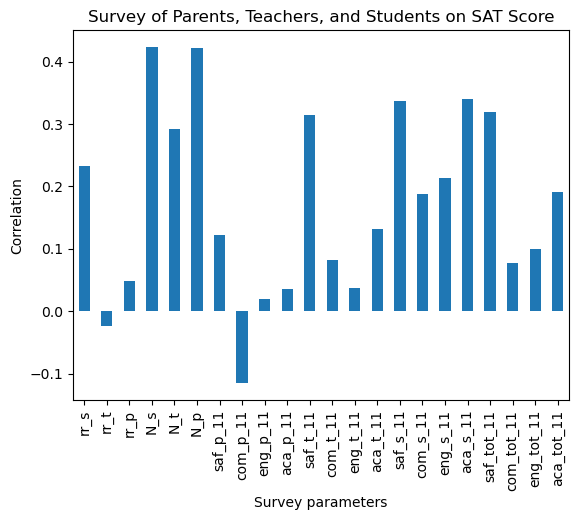

In [11]:
combined.corr()['sat_score'][survey_fields].plot.bar(title = 'Survey of Parents, Teachers, and Students on SAT Score', xlabel = 'Survey parameters', ylabel = 'Correlation')
plt.show()

From the above plot, it can be seen that there is a strong relation between the number of responses among students(N_s), teachers(N_t), parents(N_p) and sat score.

It is interesting to note that the response rate of students is high(rr_s) while that of teachers(rr_t) and parents(rr_p) is low. This is reasonable because students who perform well could be more inclined to respond to surveys.

Another point to observe is the strong correlation between safety and response rate of students(saf_s_11), teachers(saf_t_11), and total(saf_tot_11). It is difficult to teach in an insecure environment, so it makes sense that they would concerned about safety.

It is also interesting to see that students are inclined to academic expectations score(aca_s_11), while teachers(aca_t_11) and parents(aca_p_11) don't have a strong correlation with sat score.

Finally, it should also be considered that parents have a negative correlation with communication(com_p_11) and sat_score, while students(com_s_11) and teachers(com_t_11) have weak positive correlations. This could imply that parents are not satisfied with the communication system, and even teachers and students have not much to say about it in regards to sat score.

### Exploring Safety and SAT Scores

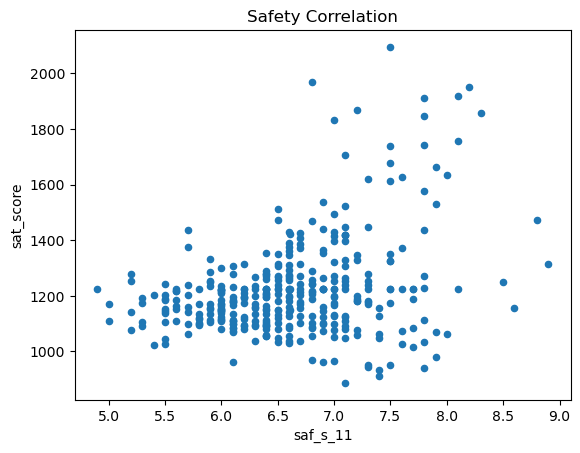

In [12]:
combined.plot.scatter(x = 'saf_s_11', y = 'sat_score', title = 'Safety Correlation')
plt.show()

The correlation is dense between safety scores of 5.0 - 7.5. When plotted against sat_scores, it can be seen that sat scores fall under an average of 1200. However, when the safety score is higher, like around 8.0 - 8.5, the sat scores go as high as 2000-2200. It can be said that most of the students are not completely safe, which might hinder their performance in SAT.

### Borough Safety

In [13]:
boro_safety_scores = combined.groupby('boro').agg(np.mean)['saf_s_11']
boro_safety_scores.sort_values(ascending = True)

boro
Brooklyn         6.370755
Staten Island    6.530000
Bronx            6.606577
Queens           6.721875
Manhattan        6.831370
Name: saf_s_11, dtype: float64

It can be seen that Queens and Manhattan are relatively safe in comparison to Brooklyn.

### Exploring Race and SAT Scores

There are a few columns that indicate the percentage of each race at a given school:
- white_per
- asian_per
- black_per
- hispanic_per


By plotting out the correlations between the columns and sat_score, it can be determined whether there are any racial differences in SAT performance.

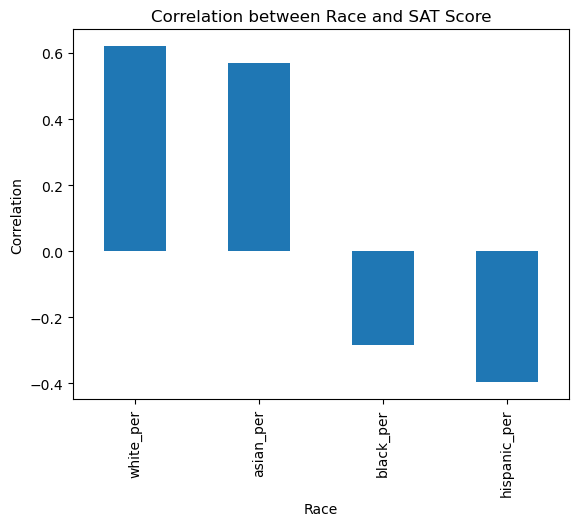

In [14]:
combined.corr()['sat_score'][['white_per','asian_per','black_per','hispanic_per']].plot.bar(title = 'Correlation between Race and SAT Score', xlabel = 'Race', ylabel = 'Correlation')
plt.show()

It can be seen that there is a positive correlation for Americans and Asians with sat score while it is not the case for African-Americans and Hispanics. This implies that Americans and Asians perform better in SAT while African-Americans and Hispanics do not. This could be attributed to lack of school fundings for the community.

#### SAT Scores and Hispanics

<AxesSubplot:xlabel='hispanic_per', ylabel='sat_score'>

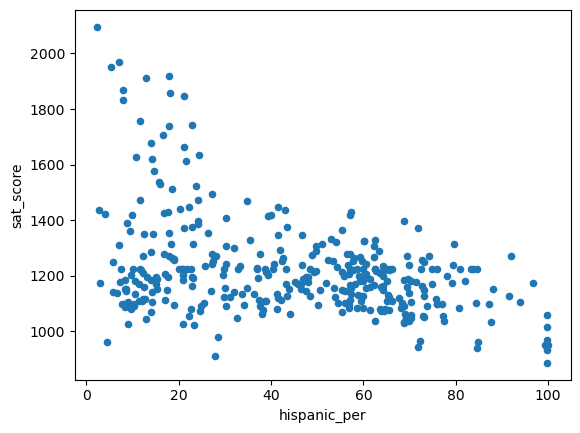

In [15]:
combined.plot.scatter(x = 'hispanic_per', y = 'sat_score')

Frpm the plot, it can be seen that the regions where the hispanic population is lower seem to obtain better sat scores in comparison to where the population is higher. This could imply that a small population of hispanics have access to better schools.

In [16]:
combined[combined['hispanic_per'] > 95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools listed above appear to primarily serve recent immigrants to the U.S. These schools have many students who are learning English, which would explain the lower SAT scores.

In [17]:
combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools listed above specialize in science and technology. It can be reasoned that students enlisted in these kind of specialized schools perform better in SAT. However, they do not necessarily cater to the recent immigrants and as such, have a high bar for admission.

### Exploring Gender and SAT Scores

There are two columns that indicate percentage of gender:
- male_per
- female_per

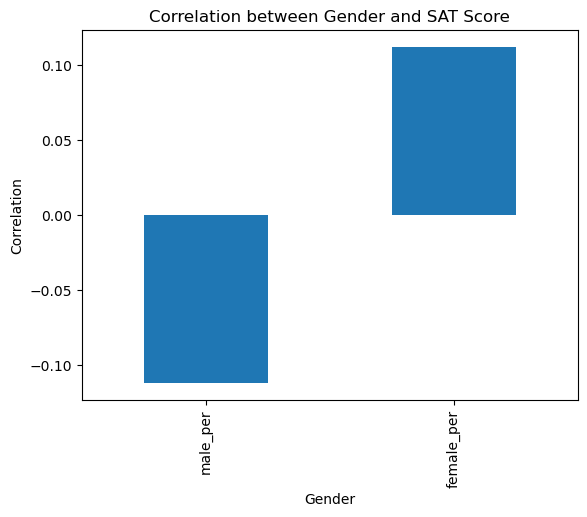

In [29]:
combined.corr()['sat_score'][['male_per','female_per']].plot.bar(title = 'Correlation between Gender and SAT Score', xlabel = 'Gender', ylabel = 'Correlation')
plt.show()

It can be seen that females have a positive correlation with sat scores, while it is not true for males. However, both the correlations are weak.

<AxesSubplot:title={'center':'Correlation of female with SAT score'}, xlabel='female_per', ylabel='sat_score'>

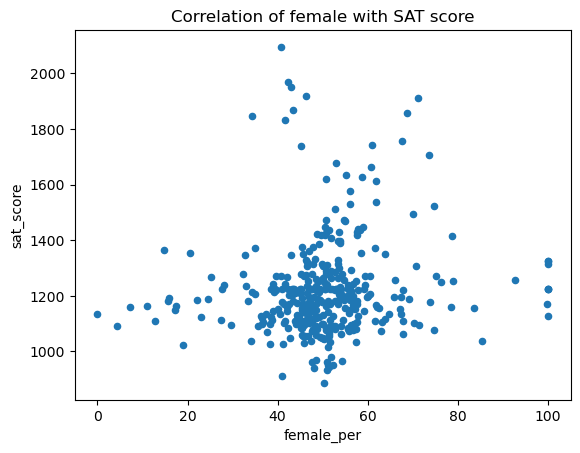

In [34]:
combined.plot.scatter(x = 'female_per', y = 'sat_score', title = 'Correlation of female with SAT score')

There is no strong correlation between sat_scores and female_per. However, there is a relation between high sat scores(>1700) and high female_per(60% - 80%)

In [36]:
combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools listed above are situated in Manhattan or Queens and most of them are specialized for college preparation, especially in fields of Arts and Science. As mentioned earlier, Manhattan and Queens tend to have higher safety scores. And, as discussed earlier, students from specialized schools tend to perform better. This could explain the higher SAT scores, and could tell us that females mostly perform better in Arts and Science courses.

### Exploring AP Scores vs. SAT Scores

In the U.S., high school students take Advanced Placement(AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores.

In [37]:
# Calculating percentage of students who have taken AP exam
combined['ap_per'] = (combined['AP Test Takers ']/combined['total_enrollment']) * 100

<AxesSubplot:xlabel='ap_per', ylabel='sat_score'>

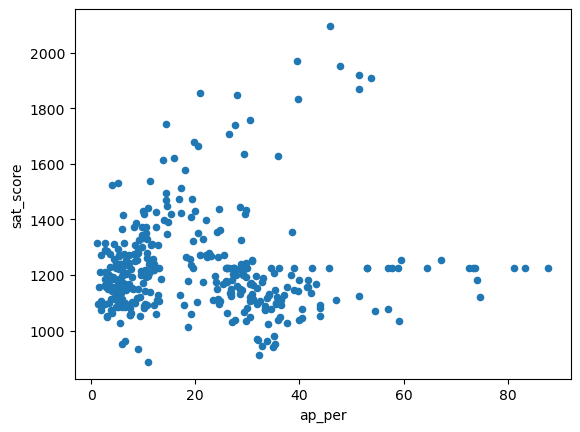

In [40]:
combined.plot.scatter(x='ap_per', y='sat_score')

Nothing could be said based on this relation

In [44]:
combined['sat_score'].mean()

1223.438805970149